# Self-consistent evaluation of summarization using LLMs

- Code below with `"microsoft/Phi-3-mini-4k-instruct"` runs on GPU P100
- Using basic settings for Microsoft Phi-3 from: [https://github.com/microsoft/Phi-3CookBook/blob/main/md/02.QuickStart/Huggingface_QuickStart.md](https://github.com/microsoft/Phi-3CookBook/blob/main/md/02.QuickStart/Huggingface_QuickStart.md)

## TODO

- Different models
- Different datasets: [https://huggingface.co/datasets/csebuetnlp/xlsum/viewer/english](https://huggingface.co/datasets/csebuetnlp/xlsum/viewer/english)
- Different prompts: currently not doing templated/extraction prompt, free prompt seems to give desired format for outputs
- Improve parsing functions: 1) converting scores to ints from the completions 2) splitting components of gold dataset summary into individual summary facts

In [1]:
import time
import torch

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from itertools import combinations
from random import sample, seed

2024-06-30 19:16:39.441164: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-30 19:16:39.441290: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-30 19:16:39.567094: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
seed(1729)
torch.random.manual_seed(0)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

In [3]:
#model_checkpoint = "microsoft/Phi-3-medium-4k-instruct"
model_checkpoint = "microsoft/Phi-3-mini-4k-instruct" # RUNS ON Kaggle GPU P100

model = AutoModelForCausalLM.from_pretrained(
    model_checkpoint, 
    device_map="cuda", 
    torch_dtype="auto", 
    trust_remote_code=True, 
)

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

config.json:   0%|          | 0.00/931 [00:00<?, ?B/s]

configuration_phi3.py:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-4k-instruct:
- configuration_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi3.py:   0%|          | 0.00/73.8k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-4k-instruct:
- modeling_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/172 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.17k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Temperature settings for experiments

- Set 0 for all experiments so far

In [4]:
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

# Set temperature to 0 for experiment
generation_args = {
    "max_new_tokens": 600,
    "return_full_text": False,
    "temperature": 0.0,
    "do_sample": False,
}

# Dataset

- Using `gursi26/wikihow-cleaned`
- Tried e.g. `CNN / DailyMail` but not impressed with the gold annotations at first glance
- Weakness of wikihow is that it's not very "business like", would prefer news articles or documents

In [5]:
ds = load_dataset("gursi26/wikihow-cleaned")

Generating train split:   0%|          | 0/214293 [00:00<?, ? examples/s]

## Functions

- Made a quick "prompt template" function, avoid importing heavy frameworks etc.
- Split summary (a single sentence, string) into a list of `num_facts_in_summary` individual facts

In [7]:
def get_wikihow_prompt(wikihow_text, wikihow_title, curr_summary):
    
    WIKIHOW_SYSTEM_PROMPT = "You are a helpful assistant who evaluates the quality of short summaries of educational text and articles."

    WIKIHOW_USER_PROMPT = f"""Here is the full text of an educational article, and a short explanation of the article's overall educational goal. This is followed by a concise summary of the article. Give a score, from 1 to 5, of the quality of the summary. If the summary gives all of the essential information from the article, give a score of 5. If the summary does not give any items that are relevant for summarizing the article, give a score of 1.

    ### Article Full Text ###
    {wikihow_text}
    
    ### Article Overall Goal ###
    {wikihow_title}

    ### Article Summary ###
    {curr_summary}

    Give your answer in the following format, without deviation:

    Score: your score, an integer value between 1 and 5.
    Explanation: a short explanation of your Score.
    Missing Information: if your score is not 5, give the most important information that the summary missed from the article."""
    
    return WIKIHOW_SYSTEM_PROMPT, WIKIHOW_USER_PROMPT


def split_summary_for_combinations(summary: str, split_str=' . '):
    summary_sentences = [x.rstrip(' ').lstrip(' ').rstrip(' .') for x in summary.split(split_str) if x]

    return summary_sentences  


def get_score_to_int(row):
    """
    Parse the "score" value from the row completion:

    Note that so far with Phi3 the prompt formatting is consistent so don't need to try/except stuff
    so just get the "number that is after Score: " basically O_o
    """
    # "Score: n......"
    # n is in index 7 <--- UPDATE IT IS IN 8!?!??! MAYBE DOUBLE SPACE I CAN'T SEE
    # TODO: make this safer/error handle O_o
    return int(row["completion"][8])

# Experiments

- For now, only sending 1 single example (i.e. a pair (text, gold summary of text))
- TODO: will need to modify logic for the dataframe / plotting steps, as will need to groupby on the "id" of the examples, and plot a graph for each individually (since concatenating all results across all examples to the same final dataframe)

### Good examples in WikiHow dataset

- By good examples I mean, make a list of "variety": it seems that in increasing index you get groups of "topics" like "animals", "life advice" etc.
- Also examples vary a lot in total size, so some with e.g. only 2 summary facts aren't as interesting as larger ones

**Interesting indices: 44,45,3115 etc**

In [9]:
EXPERIMENTS_DATASET_TRAIN_INDICES = [44] # 44,45,3115 etc, for now only 1

for example_idx in EXPERIMENTS_DATASET_TRAIN_INDICES:
    wikihow_example = ds["train"][example_idx]
    print(f"**** EXPERIMENT WITH {wikihow_example['text']} ****")
    print("***" * 30)
    
    wikihow_facts_from_summary = split_summary_for_combinations(wikihow_example["summary"])
    wikihow_num_facts_total = len(wikihow_facts_from_summary)
    
    # TODO: improve if need better performance when larger summaries
    wikihow_num_facts_sampler = list(range(1, wikihow_num_facts_total + 1))

    # save results to rows[] for later processing
    wikihow_rows = []

    wiki_start_time = time.time()

    for num_facts_to_include in wikihow_num_facts_sampler:
        print(f"==== PROCESSING EXAMPLES CONSISTING OF : {num_facts_to_include} FACTS ====")
        
        # Generate all combinations of facts:
        all_combs = list(combinations(wikihow_facts_from_summary, num_facts_to_include))
        # ... then sample from them, else will timeout O_o

        # TODO: improve, maybe take more combos for the intermediate values of 'k'
        number_of_combos_to_sample = min(len(all_combs), wikihow_num_facts_total)
        it = sample(all_combs, number_of_combos_to_sample)

        for selected_facts in it:
            # produce the article summary from these selected_facts
            # currently join with ' . ' so that format is same as original wikihow dataset
            JOIN_CHAR = ' . '
            curr_wikihow_summary = JOIN_CHAR.join(selected_facts)
            curr_wikihow_text = wikihow_example["text"]
            curr_wikihow_title = wikihow_example["title"]

            print("PROCESSING : ", curr_wikihow_summary)

            # send this to model
            system_prompt, user_prompt = get_wikihow_prompt(curr_wikihow_text, curr_wikihow_title, curr_wikihow_summary)
            messages = [
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt},
            ]
            res = pipe(messages, **generation_args)

            wikihow_rows.append({
                "example_index_in_dataset": example_idx,
                "num_facts": num_facts_to_include,
                "selected_facts": selected_facts,
                "completion": res[0]['generated_text'],
            })        

    wiki_end_time = time.time()

**** EXPERIMENT WITH when working with a horses hooves its important to move the horses foot into position in a way that doesnt surprise the horse or irritate it . make sure the horse is aware of your presence by gently patting it on the rump . to get your horse to lift her foot , run your hand down her leg . then , squeeze the tendon above the ankle and lift the hoof . the horse should shift its weight to its other three feet . while you work , hold the foot in place by tucking your hip against the horses hock the large joint on the hind leg and gaskin the muscle above the hock . use the inside of your knee to pull the foot out slightly and up between your legs so that the sole of the hoof faces up towards you . support the horses toe with one hand . this position locks the horses foot in place , making it difficult for the horse to kick or put its foot on the ground before youre done working . make sure that you reward your horse with praise for cooperating and waiting while you clea

/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


PROCESSING :  lift the horses foot
PROCESSING :  size the shoe to its hoof
PROCESSING :  secure the shoe in its place with nails
PROCESSING :  make minor adjustments to the shape of the shoe , if needed
PROCESSING :  clean the bottom of the hoof
PROCESSING :  use a rasp to flatten and level the the sole
PROCESSING :  file any rough spots on the hoof wall
PROCESSING :  remove any shoes that are already on the horses feet
PROCESSING :  bend and remove the nail tips


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


PROCESSING :  use a hoof knife to remove excess , flaky sole from the bottom of the hoof
PROCESSING :  trim excess hoof wall with hoof nippers
PROCESSING :  repeat process three more times until all four hooves have been shod
==== PROCESSING EXAMPLES CONSISTING OF : 2 FACTS ====
PROCESSING :  clean the bottom of the hoof . size the shoe to its hoof
PROCESSING :  remove any shoes that are already on the horses feet . bend and remove the nail tips
PROCESSING :  secure the shoe in its place with nails . file any rough spots on the hoof wall
PROCESSING :  make minor adjustments to the shape of the shoe , if needed . secure the shoe in its place with nails
PROCESSING :  lift the horses foot . remove any shoes that are already on the horses feet
PROCESSING :  size the shoe to its hoof . secure the shoe in its place with nails
PROCESSING :  trim excess hoof wall with hoof nippers . clinch the nail
PROCESSING :  use a rasp to flatten and level the the sole . size the shoe to its hoof
PROCESSIN

## TODO: modify this when you run more than 1 example in an experiment

- Currently assumes dataframe has only 1 distinct "experiment id"

In [10]:
wikihow_df = pd.DataFrame(wikihow_rows)
wikihow_df["score"] = wikihow_df.apply(get_score_to_int, axis=1)
simple_df = wikihow_df[["num_facts", "score"]]

In [11]:
simple_df.head()

,num_facts,score
0,1,1
1,1,1
2,1,5
3,1,3
4,1,2


# Plot results for each example sent to LLM

/tmp/ipykernel_34/3567036239.py:7: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  p = sns.swarmplot(x="num_facts", y="score", data=simple_df, size=5, palette="tab10")
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = g

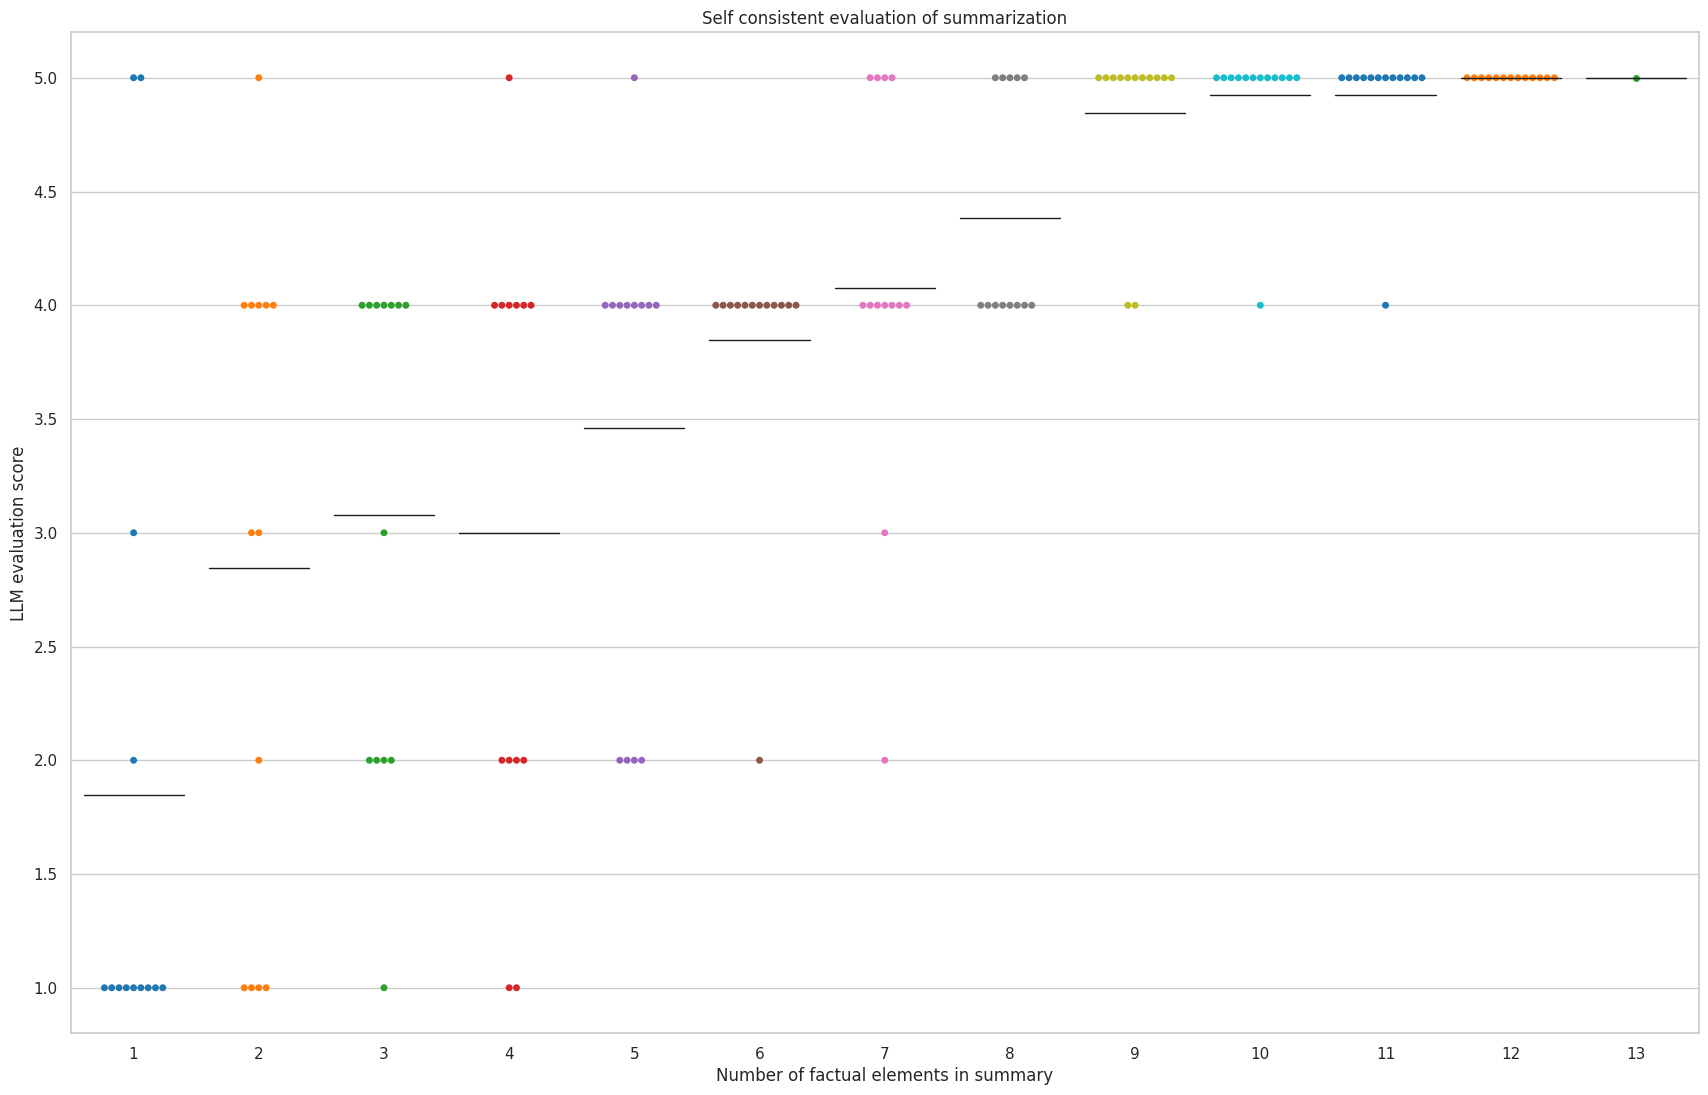

In [19]:
sns.set(style='whitegrid')

# Code from:
# https://stackoverflow.com/questions/67481900/how-to-add-a-mean-line-to-a-seaborn-stripplot-or-swarmplot
# note: need to adjust size if have more points else they don't fit in swarmplot O_o
plt.figure(figsize=(21, 13))
p = sns.swarmplot(x="num_facts", y="score", data=simple_df, size=5, palette="tab10")

ax=sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 1},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="num_facts",
            y="score",
            data=simple_df,
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=p)

plt.title('Self consistent evaluation of summarization')
ax.set_ylabel("LLM evaluation score")
ax.set_xlabel("Number of factual elements in summary")
plt.show()

In [21]:
import json

with open('llm-self-con-eval.json', 'w') as fo:
    json.dump(wikihow_rows, fo, indent=4, ensure_ascii=True)